<a href="https://colab.research.google.com/github/Franklingo13/ejemplosCopernicus/blob/main/ejemplosJupyter/riesgoErosion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cuaderno python para probar el uso de los datos de la API de Copernicus

#Estimación del riesgo de erosión en función de los períodos de suelo desnudo y la pendiente del modelo de elevación digital

En el primer paso, se importan las dependencias, incluido getpass para administrar credenciales, matplotlib para la visualización de imágenes y una serie de funciones del paquete Sentinel Hub.

In [2]:
%pip install sentinelhub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.8/249.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00


In [3]:
import getpass

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    MimeType,
    MosaickingOrder,
    SentinelHubRequest,
    SentinelHubStatistical,
    SHConfig,
)

##Credenciales
Las credenciales para los servicios de Sentinel Hub ( client_id& client_secret) se pueden obtener en su Panel de Control . En la Configuración de Usuario, puede crear un nuevo Cliente OAuth para generar estas credenciales. Para obtener instrucciones más detalladas, visite la página de documentación correspondiente .

Ahora que tiene su client_id & client_secret, se recomienda configurar un nuevo perfil en su paquete de Python de Sentinel Hub.

In [4]:
# Only run this cell if you have not created a configuration.

config = SHConfig()
config.sh_client_id = getpass.getpass("sh-58a81495-a763-476f-b7a0-e06628d6d237")
config.sh_client_secret = getpass.getpass("iuVxClHw9OoVcOH3R28DItWkOTbVj2PT")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.save("cdse")

sh-58a81495-a763-476f-b7a0-e06628d6d237··········
iuVxClHw9OoVcOH3R28DItWkOTbVj2PT··········


Definición del cuadro de la región de interés
box: -78.775184,-2.889990,-78.762588,-2.879633

In [5]:
bbox = BBox((-78.775184,-2.889990,-78.762588,-2.879633), crs=CRS.WGS84).transform(3035)
time_interval = "2023-04-01", "2023-09-01"
resolution = (50, 50)

##Obtener el número de días de suelo desnudo


In [6]:
evalscript_bare_soil = """
//VERSION=3
function setup() {
  return {
    input: ["B02", "B04", "B08", "B11", "B12", "SCL", "dataMask"],
    output: { bands: 3, sampleType: "UINT16" },
    mosaicking: "ORBIT",
  };
}

function isCloud(sample) {
  // Define codes as invalid:
  const invalid = [
    0, // NO_DATA
    1, // SATURATED_DEFECTIVE
    3, // CLOUD_SHADOW
    7, // CLOUD_LOW_PROBA
    8, // CLOUD_MEDIUM_PROBA
    9, // CLOUD_HIGH_PROBA
    10, // THIN_CIRRUS
  ];
  return !invalid.includes(sample.SCL);
}

function evaluatePixel(samples) {
  let [nBare, nNonBare, nCloud] = [0, 0, 0];
  for (let i = 0; i < samples.length; i++) {
    let s = samples[i];
    if (s.dataMask === 0) {
      continue;
    }
    if (isCloud(s)) {
      nCloud++;
      continue;
    }
    // bareness index
    let mbi =
      (2.5 * (s.B11 + s.B04 - (s.B08 + s.B02))) /
      (s.B11 + s.B04 + (s.B08 + s.B02));
    if (mbi > 0) {
      nBare++;
    } else {
      nNonBare++;
    }
  }
  return [nBare, nNonBare, nCloud];
}

"""

Definición de una solicitud a la API de sentinelhub. La autorización para esta solicitud se gestiona mediante el archivo `config`.

In [7]:
request = SentinelHubRequest(
    evalscript=evalscript_bare_soil,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                "s2l2a", service_url=config.sh_base_url
            ),
            time_interval=time_interval,
            mosaicking_order=MosaickingOrder.MOST_RECENT,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox,
    resolution=resolution,
    config=config,
    data_folder="./data",
)

In [8]:
bare_soil = request.get_data(save_data=True)[0]

Se calcula la relación entre los días de suelo desnudo y el total de días sin nubes para cada píxel: esta relación constituye nuestro parámetro de salida final. Utilizamos matplotlib pyplot para visualizar una imagen de este índice para el área de estudio.

Las áreas azules no presentan suelo desnudo, pero están cubiertas de vegetación durante todo el período estudiado. Las áreas amarillas presentan una alta proporción de suelo desnudo y, potencialmente, suelo descubierto durante todo el período estudiado.

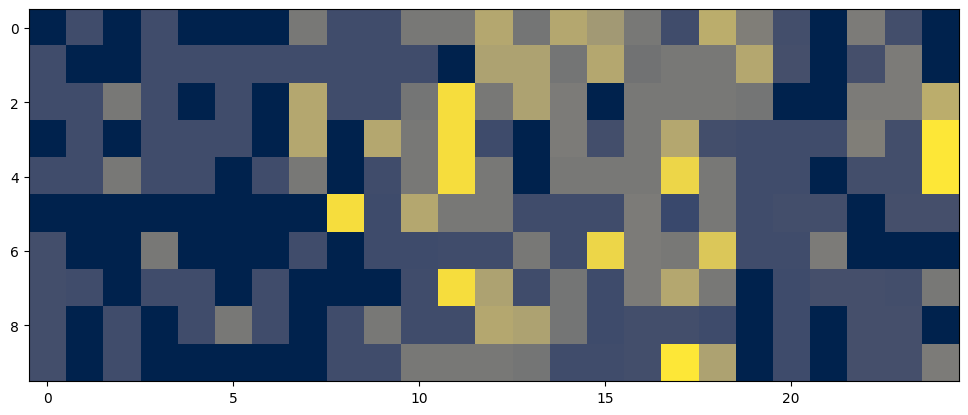

In [9]:
total_clear = bare_soil[:, :, 1] + bare_soil[:, :, 0]
bare_ratio = bare_soil[:, :, 0] / total_clear

# show image of bare soil ratio for the area of interest.

plt.figure(figsize=(12, 12))
plt.imshow(bare_ratio, cmap="cividis");

## Obtención de la pendiente del terreno

In [ ]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["slope", "dataMask"],
    output: { bands: 1, sampleType: "FLOAT32" },
  };
}

function evaluatePixel(samples) {
  return [samples.slope];
}
"""

Para generar una imagen en color real se usará el mosaico trimestral de Sentinel-2 sin nubes. La visualización se realiza mediante una solicitud a la API de procesos, basada en la colección de la fuente de datos y el evalscript para la visualización en color real.

In [10]:
S2l3_cloudless_mosaic = DataCollection.define_byoc(
    collection_id="5460de54-082e-473a-b6ea-d5cbe3c17cca"
)

## Obtención de imagen de color verdadero

In [11]:
evalscript_true_color = """
//VERSION=3
function setup() {
  return {
    input: ["B04","B03","B02", "dataMask"],
    output: { bands: 4 }
  };
}

// Contrast enhance / highlight compress

const maxR = 3.0; // max reflectance
const midR = 0.13;
const sat = 1.2;
const gamma = 1.8;
const scalefac = 10000;

function evaluatePixel(smp) {
  const rgbLin = satEnh(sAdj(smp.B04/scalefac), sAdj(smp.B03/scalefac), sAdj(smp.B02/scalefac));
  return [sRGB(rgbLin[0]), sRGB(rgbLin[1]), sRGB(rgbLin[2]), smp.dataMask];
}

function sAdj(a) {
  return adjGamma(adj(a, midR, 1, maxR));
}

const gOff = 0.01;
const gOffPow = Math.pow(gOff, gamma);
const gOffRange = Math.pow(1 + gOff, gamma) - gOffPow;

function adjGamma(b) {
  return (Math.pow((b + gOff), gamma) - gOffPow)/gOffRange;
}

// Saturation enhancement
function satEnh(r, g, b) {
  const avgS = (r + g + b) / 3.0 * (1 - sat);
  return [clip(avgS + r * sat), clip(avgS + g * sat), clip(avgS + b * sat)];
}

function clip(s) {
  return s < 0 ? 0 : s > 1 ? 1 : s;
}

//contrast enhancement with highlight compression
function adj(a, tx, ty, maxC) {
  var ar = clip(a / maxC, 0, 1);
  return ar * (ar * (tx/maxC + ty -1) - ty) / (ar * (2 * tx/maxC - 1) - tx/maxC);
}

const sRGB = (c) => c <= 0.0031308 ? (12.92 * c) : (1.055 * Math.pow(c, 0.41666666666) - 0.055);"""

Solicitud de API de proceso para obtener una imagen en color real del área de estudio.

In [12]:
request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=S2l3_cloudless_mosaic,
            time_interval=time_interval,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=bbox,
    resolution=(10, 10),
    config=config,
    data_folder="./data",
)

Se cargan los datos de solicitud en una variable

In [13]:
true_color_imgs = request_true_color.get_data(save_data=True)
image = true_color_imgs[0]

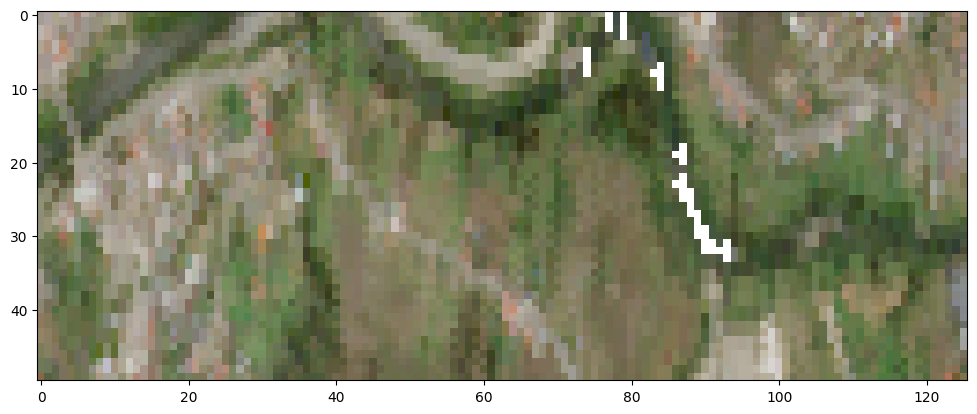

In [17]:
# Mostrar la imagen de color real

plt.figure(figsize=(12, 12))
plt.imshow(image)
